# Attributions

**Emily:** Bullk of question

**Chris:** Checked over finalized work

**Naveen:** Checked over finalized work

C:\Users\hklum\Anaconda3\lib\site-packages\odo\backends\pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


Loading BokehJS ...


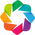

In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import bebi103

import bokeh.plotting
import bokeh.io
bokeh.io.output_notebook()

import holoviews as hv
hv.extension('bokeh')

# Holoviews preferences
%opts Scatter [show_grid=True, height=300, width=450] (color='#1f77b4', alpha=0.25)
%opts Curve (color='#ff7f0e')

Nonconstant $k$ would probably affect the analysis (maybe not much because we saw the spread was only $\pm 25\%$ off the mean but still) because it would become a variable in $\gamma$ as opposed to a constant, as we can see from the derivation of $\gamma$ in lecture 3:

$$ \gamma = \bigg(\frac{T_0-T_{min}}{k^2T_s} \bigg)^{1/3}$$

Then, $k$ would need to be considered separate of $\gamma$. This is possible to do, though, because we have defined $k = w/l$, both values of which we have. This means that for every value of $\gamma$, we can directly calculate the corresponding $k$ value from the data, then feed it into the statistical model for calculations. We can then redefine $\gamma$ (which is the definition I will refer to from now on) as:

$$\gamma = \bigg(\frac{T_0-T_{min}}{T_s}\bigg)^{1/3}$$

since the $\frac{1}{k^2}$ term will be handled separately. The new mathematical expression would then be:

$$ l(d, k \,; \gamma, \phi) = \frac{\gamma d}{k^{2/3}(1+(d/\phi)^3)^{1/3}} $$

In [2]:
# Load in Data Frame
df = pd.read_csv('../data/good_invitro_droplet_data.csv', comment='#')

Modifying the code from Tutorial 4a for the tubulin conservation model, let's first make some functions that can give us the log likelihood. We simply have to account for the new $\frac{1}{k^{2/3}}$ in the calculations, feeding in $k$ as another variable for each function.

In [3]:
def spindle_length(params, d, k):
    """Spindle length as a function of droplet diameter."""
    # Unpack parameters
    gamma, phi = params
    
    # Compute spindle length
    return gamma * d / (k**(2/3)*np.cbrt(1 + (d/phi)**3))


def resid(params, d, k, ell):
    """Residuals for spindle length model."""
    return ell - spindle_length(params, d, k)


def log_marg_like_cons_tubulin(params, d, k, ell):
    """Log of marginlized likelihood."""
    return -len(d) / 2 * np.log(np.sum(resid(params, d, k, ell)**2))

Now, we can code up the log prior.

In [4]:
def log_marg_prior_cons_tubulin(params, gamma_range, phi_range):
    """Log prior of marginalized prior for conservation of tubulin model"""
    gamma, phi = params
    
    if ( not(gamma_range[0] <= gamma <= gamma_range[1]) 
             or not(phi_range[0] <= phi <= phi_range[1])):
        return -np.inf
    
    return -np.log(phi)

Putting together the prior and likelihood for the posterior:

In [5]:
def log_marg_post_cons_tubulin(params, d, k, ell, gamma_range, phi_range):
    """Log posterior for conservation of tubulin model."""
    lp = log_marg_prior_cons_tubulin(params, gamma_range, phi_range)

    if lp == -np.inf:
        return -np.inf

    return lp + log_marg_like_cons_tubulin(params, d, k, ell)

Writing a function to give us values for a contour plot:

In [6]:
def post_cons_tubulin_plot(gamma, phi, d, k, ell, gamma_range, phi_range):
    """Log posterior from conservation of tubulin model for plotting."""
    log_post = np.empty((len(phi), len(gamma)))
    for j, g in enumerate(gamma):
        for i, p in enumerate(phi):
            log_post[i, j] = log_marg_post_cons_tubulin((g, p),
                                                        d,
                                                        k,
                                                        ell,
                                                        gamma_range,
                                                        phi_range)
    
    # Scale properly
    log_post -= log_post.max()
    
    # Compute meshgrid
    GAMMA, PHI = np.meshgrid(gamma, phi)

    return GAMMA, PHI, np.exp(log_post)

Plotting the contour plot!

In [7]:
# Set up allowed ranges for gamma and phi
gamma_range = (0, 1)
phi_range = (0, np.inf)
k = df['Spindle Width (um)'].values / df['Spindle Length (um)'].values

# Set up ranges of gamma and phi for plotting
gamma = np.linspace(0.38, 0.42, 200)
phi = np.linspace(50, 60, 200)

# Compute posterior for plotting
GAMMA, PHI, POST = post_cons_tubulin_plot(gamma,
                                          phi,
                                          df['Droplet Diameter (um)'].values,
                                          k,
                                          df['Spindle Length (um)'].values,
                                          gamma_range,
                                          phi_range)

# Build and show plot
p = bebi103.viz.contour(GAMMA,
                        PHI,
                        POST,
                        x_axis_label='γ',
                        y_axis_label='φ (µm)',
                        overlaid=True)
bokeh.io.show(p)

Note that the axes are changed because of the way we have redefined $\gamma$. However, noting the shape of the contour plot, it looks really rather similar to the one in the tutorial for the tubulin conservation one, meaning the assumption that k is constant is probably fairly accurate! Nice.

<div class="alert alert-info">Final: 6.5/10  
Good work! But note that conserving the shape of the posterior is not the only interesting thing - we want to know if the MAP (the most likely parameters, given the data) has changed! It would be useful to estimate the parameters again with optimization and see how different they are. (You will see ~25-50% changes in most likely values.) Also, it's worth explaining why the same statistical model applied after you changed your mathematical model.</div>